In [1]:
#Importing things 
import torch, sys, random, torch
import numpy as np
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
from IPython import display
import pygame
import random
from enum import Enum
from collections import namedtuple
import numpy as np
# Edit params
# graph things 

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Readme
The following program can be broken into three main sections: Agent, Model, Game. Each one of these sections is their own class and from a very high level work in the following way. The agent creates instances of the model and game and run the game while collecting information from the game and passing it into the model to make decisions before being told how good that decision was (what reward they get) and training the model based on the games feedback.

In [2]:
width = 640
height = 480
x_pos = 100
y_pos = 200
size_cell = 20
num_cells = 32
num_cells_height = 24
game_speed = 40 # effects how fast the snake moves (the value is the time in mili secs that it takes for the snake to move)
max_Games = 1000 # controls how many games the agent will play for 
red = (196, 14, 14) # colour of the food
green = (96, 207, 74) # colour of the background
blue = (10, 69, 171) # colour of the snake

In [3]:
#Agent

mem_size = 100000
batch_size = 1000
learning_rate = 0.001

# Game

In [4]:
pygame.init()

class DireC(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4
#basically a vector but makes more sense to be called a block in this instace as we are working with a grid
Block = namedtuple('Block', 'x, y')

class Game:

    def __init__(self):
        self.width = width
        self.height = height
        self.display = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()
        self.restart()

# Create snake and food
    def restart(self):
        self.snake = Snake(self)
        self.score = 0
        self.food = None
        self.position_food()
        self.game_step = 0


    def position_food(self):
        x = random.randint(0, (self.width - size_cell) // size_cell) * size_cell #removing edge cases 
        y = random.randint(0, (self.height - size_cell) // size_cell) * size_cell #removing edge cases 
        self.food = Block(x, y)
        if self.food in self.snake.body: #Stops food from spawning in snake
            self.position_food()


    def play_step(self, action):
        self.game_step += 1
        for event in pygame.event.get(): # See if user quit
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
        
        self.move_snake(action) # Add new block to front of the direction snake moved 
        self.snake.body.insert(0, self.snake.head)
        
        #check if snake died
        reward = 0
        game_end = False                                    
        if self.check_collision() or self.game_step > 100 * (self.score + 3):# giving snake a max step count of number of chunks times 100
            game_end = True
            reward = -10
            return reward, game_end, self.score

        # Check if snake ate food
        if self.snake.head == self.food:
            self.score += 1
            reward = 15
            self.position_food()
        else:
            self.snake.body.pop() # if snake did not eat then remove the tail from snake since we added a block to the front
        
        # refresh screen
        self.refresh_display()
        self.clock.tick(game_speed)
        return reward, game_end, self.score


    def check_collision(self, chunk = None):
        if chunk is None:
            chunk = self.snake.body[0] #checking if a chunk was passed in otherwise use head
         # Checking map edges
        if chunk.x > self.width - size_cell or chunk.x < 0 or chunk.y > self.height - size_cell or chunk.y < 0:
            return True
         # Checking if snake hits itself 
        for chunk in self.snake.body[1:]:
            if chunk == self.snake.body[0]:
                return True

        return False


    def refresh_display(self):
        self.display.fill(green)

        for chunk in self.snake.body:
            pygame.draw.rect(self.display, blue, pygame.Rect(chunk.x, chunk.y, size_cell, size_cell))

        pygame.draw.rect(self.display, red, pygame.Rect(self.food.x, self.food.y, size_cell, size_cell))

        pygame.display.update()


        #Take in current direction of snake and then turn it based on what NN says to do 
    def move_snake(self, action):
#       [straight, right, left]
        clock_wise = [DireC.RIGHT, DireC.DOWN, DireC.LEFT, DireC.UP] # array positioned this way to do a little hack for 
        curr_dir_index = clock_wise.index(self.snake.direc)                # changing direction where you take array index and add one to turn 
                                                                     # right and subtract one to turn left
        if np.array_equal(action, [1, 0, 0]): #straight
            dir_temp = clock_wise[curr_dir_index] # no change
        elif np.array_equal(action, [0, 1, 0]): #right
            curr_dir_index_temp = (curr_dir_index + 1) % 4
            dir_temp = clock_wise[curr_dir_index_temp] # turn clockwise
        else: #left [0, 0, 1]
            curr_dir_index_temp = (curr_dir_index - 1) % 4
            dir_temp = clock_wise[curr_dir_index_temp] # turn counter clockwise
            
        self.snake.direc = dir_temp

        x = self.snake.head.x
        y = self.snake.head.y
        #making sure the block is added in the right direction
        if self.snake.direc == DireC.RIGHT:
            x += size_cell
        elif self.snake.direc == DireC.LEFT:
            x -= size_cell
        elif self.snake.direc == DireC.DOWN:
            y += size_cell
        elif self.snake.direc == DireC.UP:
            y -= size_cell

        self.snake.head = Block(x, y)

In [5]:
class Snake(Game):
    def __init__(self, game):
        self.game = game
        self.reset_snake()
        
    def reset_snake(self):
        self.direc = DireC.RIGHT
        self.head = Block(self.game.width / 2, self.game.height / 2)
        self.body = [self.head, Block(self.head.x - size_cell, self.head.y), Block(self.head.x - (2 * size_cell), self.head.y)]

# Agent

In [6]:
plt.ion() #making graph interactive

# removes old graph and makes a new graph
def make_graph(scrs, scrs_mean):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf() # clearing old graph
    plt.title('Double Deep Q learning')
    plt.xlabel('Number of Itterations')
    plt.ylabel('Score')
    plt.plot(scrs)
    plt.plot(scrs_mean)
    plt.ylim(ymin=0)
    plt.text(len(scrs)-1, scrs[-1], str(scrs[-1])) #value for that run
    plt.text(len(scrs_mean)-1, scrs_mean[-1], str(scrs_mean[-1])) #average for the snake
    plt.show(block=False)
    plt.pause(.1)

In [7]:
class Agent:

    def __init__(self):
        self.num_games = 0
        self.randomness = 0 #epsilon
        self.dis_rate = 0.9 #discount rate (must be smaller then 1)
        self.mem = deque(maxlen = mem_size) #will call popleft if there is more then mem size 
        self.model = deepQ(11, 256, 3)# params (input size, hidden size, output size)
        self.trainer = QTrain(self.model, learning_rate = learning_rate, gamma = self.dis_rate)
        self.trade_off_games = 80 # number of games for exploration before exploitation
        

        
        #State is an 11 value binary array
        #The first 3 are if there is a wall ahead, right and, left of the snake
        #The next 4 indicate the current direction the snake is moving (Left, Right, Up, Down)
        #The last 4 are where the food is relative to the head of the snake(Left, Right, Up, Down)
    def state(self, game):
        head = game.snake.body[0]
        observation_l = Block(head.x - 20, head.y) # 20 is the observation distance because the grid is only a 40X40
        observation_r = Block(head.x + 20, head.y)
        observation_u = Block(head.x, head.y - 20)
        observation_d = Block(head.x, head.y + 20)
        
#         One of these is True the rest false
        cur_dir_u = game.snake.direc == DireC.UP
        cur_dir_d = game.snake.direc == DireC.DOWN
        cur_dir_r = game.snake.direc == DireC.RIGHT
        cur_dir_l = game.snake.direc == DireC.LEFT
        
        temp_u = game.check_collision(observation_u)
        temp_d = game.check_collision(observation_d)
        temp_r = game.check_collision(observation_l)
        temp_l = game.check_collision(observation_r)
#         print(temp_u, temp_d, temp_r, temp_l)
        
        state = [
#             wall ahead
            (cur_dir_u and temp_u) or
            (cur_dir_d and temp_d) or
            (cur_dir_r and temp_r) or
            (cur_dir_l and temp_l),
            
#             wall right
            (cur_dir_u and temp_r) or
            (cur_dir_d and temp_l) or
            (cur_dir_r and temp_d) or
            (cur_dir_l and temp_u),
            
            #wall right
            (cur_dir_u and temp_l) or
            (cur_dir_d and temp_r) or
            (cur_dir_r and temp_u) or
            (cur_dir_l and temp_d),
            
            #Current direction moving (all are false but one)
            cur_dir_u,
            cur_dir_d,
            cur_dir_r,
            cur_dir_l,
            
            #where food is
            game.food.x < game.snake.head.x, # food is to left of snake head
            game.food.x > game.snake.head.x, # food is to right of snake head
            game.food.y < game.snake.head.y, # food is above snake head
            game.food.y > game.snake.head.y # food is below snake head
        ]
        
        return np.array(state, dtype=int)#little hack to covert bools to ints

    def store(self, state, action, reward, state_n, game_end):
        self.mem.append((state, action, reward, state_n, game_end))
        
        #Training that happens at the end of the game
    def train_l_mem(self):
        if len(self.mem) > batch_size:
            sample = random.sample(self.mem, batch_size)
        else:
            sample = self.mem
        
        states, actions, rewards, states_n, game_ends = zip(*sample) #combining all of the states in the batch into states, actions, and so on
        self.trainer.train_step(states, actions, rewards, states_n, game_ends)

        #Is the training that happens on each step of the game
    def train_s_mem(self, state, action, reward, state_n, game_end):
        self.trainer.train_step(state, action, reward, state_n, game_end)

    def action(self, state):
        # exploration vs exploitation
        self.randomness = self.trade_off_games - self.num_games
        move = [0, 0, 0]
        if random.randint(0, 200) < self.randomness:
            move_index = random.randint(0, 2)
            move[move_index] = 1
        else:
            state_0 = torch.tensor(state, dtype = torch.float)
            pred = self.model(state_0)
            move_index = torch.argmax(pred).item() #passing it to NN and taking the highest output value
            move[move_index] = 1
            
        
        return move


def train():
    scores = []
    mean_scores = []
    total = 0
    best_score = 0
    agent = Agent()
    game = Game()
    while True:
        # get previous state
        state = agent.state(game)

        # get move
        move = agent.action(state)

        # perform move and get new state
        reward, game_end, score = game.play_step(move)
        Nstate = agent.state(game)

        # train short memory
        agent.train_s_mem(state, move, reward, Nstate, game_end)

        # remember
        agent.store(state, move, reward, Nstate, game_end)

        if game_end == True:
            # train long memory, plot result
            game.restart()
            agent.num_games += 1
            agent.train_l_mem()

            if score > best_score:
                best_score = score

            print("Game NO:", agent.num_games, "Score:", score, "Top Score:", best_score)

            scores.append(score)
            total += score
            mean_score = total / agent.num_games
            mean_scores.append(mean_score)
            make_graph(scores, mean_scores)
            
            if agent.num_games == max_Games:
                print("Best Score: ", best_score, " Average Score: ", mean_scores[-1])
                pygame.quit()
                quit()

# Model

In [8]:
class deepQ(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size) # comment out to make it Deep Q and leave in for double deep
        self.l3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))# comment out to make it Deep Q and leave in for double deep
        x = self.l3(x)
        return x

In [9]:
class QTrain:
    def __init__(self, model, learning_rate, gamma):
        self.learning_rate = learning_rate
        self.model = model
        self.gamma = gamma
        self.optim = optim.Adam(model.parameters(), lr = self.learning_rate) #optimizer
        self.criterion = nn.MSELoss() #mean squared error
        
    def train_step(self, state, action, reward, state_n, game_end):
        state = torch.tensor(state, dtype = torch.float)
        state_n = torch.tensor(state_n, dtype = torch.float)
        action = torch.tensor(action, dtype = torch.long)
        reward = torch.tensor(reward, dtype = torch.float)
        
        #handle multiple sizes
        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            state_n = torch.unsqueeze(state_n, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            game_end = (game_end, )
        #predic q val with current state    
        pred = self.model(state)
        
        targ = pred.clone()
        for index in range(len(game_end)):
            Q_new = reward[index]
            if not game_end[index]:
                Q_new  = reward[index] + self.gamma * torch.max(self.model(state_n[index]))
            targ[index][torch.argmax(action[index]).item()] = Q_new 
        self.optim.zero_grad()
        loss = self.criterion(targ, pred)
        loss.backward()
        self.optim.step()

<Figure size 640x480 with 0 Axes>

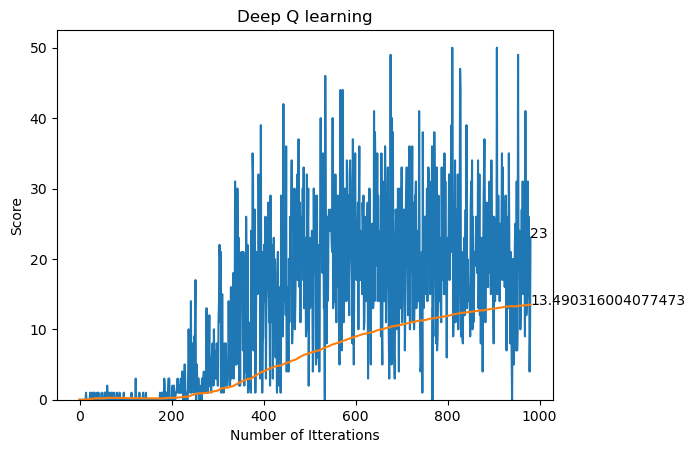

In [ ]:
train()    